# Look at accelerometer data 

Finding Zero velocity times by rail axis acceleration noise levels, making summary statistics for the noise levels across the whole day files.  Spot check graphs to see what works

In [1]:
#Standard Header used on the projects

#first the major packages used for math and graphing
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import scipy.special as sp

#Custome graph format style sheet
#plt.style.use('Prospectus.mplstyle')

#If being run by a seperate file, use the seperate file's graph format and saving paramaeters
#otherwise set what is needed
if not 'Saving' in locals():
    Saving = False
if not 'Titles' in locals():
    Titles = True
if not 'Ledgends' in locals():
    Ledgends = True
if not 'FFormat' in locals():
    FFormat = '.png'

#Standard cycle to make black and white images and dashed and line styles
default_cycler = (cycler('color', ['0.00', '0.40', '0.60', '0.70']) + cycler(linestyle=['-', '-', '-', '-']))
plt.rc('axes', prop_cycle=default_cycler)
my_cmap = plt.get_cmap('gray')

In [2]:
#Extra Headers:
import os as os
import pywt as py
import statistics as st
import os as os
import random
import multiprocessing
from joblib import Parallel, delayed
import platform

from time import time as ti

In [3]:
import CoreFunctions as cf
from skimage.restoration import denoise_wavelet

## Choosing Platform
Working is beinging conducted on several computers, and author needs to be able to run code on all without rewriting..  This segment of determines which computer is being used, and sets the directories accordingly.

In [4]:
HostName = platform.node()

if HostName == "Server":
    Computer = "Desktop"   
elif HostName[-6:] == 'wm.edu':
    Computer = "SciClone"
elif HostName == "SchoolLaptop":
    Computer = "LinLap"
elif HostName == "WTC-TAB-512":
    Computer = "PortLap"
else:
    Computer = "WinLap"

In [5]:
if Computer == "SciClone":
    location = '/sciclone/home20/dchendrickson01/image/'
elif Computer == "WinLap":
    location = 'C:\\Data\\'
elif Computer == "Desktop":
    location = "E:\\Backups\\Dan\\CraneData\\"
elif Computer == "LinLap":
    location = '/home/dan/Output/'
elif Computer == 'PortLap':
    location = 'C:\\users\\dhendrickson\\Desktop\\AccelData\\'

In [6]:
if Computer ==  "SciClone":
    rootfolder = '/sciclone/home20/dchendrickson01/'
    folder = '/sciclone/scr10/dchendrickson01/Recordings2/'
    imageFolder = '/sciclone/scr10/dchendrickson01/Move3Dprint/'
elif Computer == "Desktop":
    rootfolder = location
    folder = rootfolder + "Recordings2\\"
elif Computer =="WinLap":
    rootfolder = location
    folder = rootfolder + "Recordings2\\"   
elif Computer == "LinLap":
    rootfolder = '/home/dan/Data/'
    folder = rootfolder + 'Recordings2/'
elif Computer =='PortLap':
    rootfolder = location 
    folder = rootfolder + 'Recordings2\\'

## Global Variables

In [7]:
Saving = False
location = folder
Titles = True
Ledgends = True

f = 0


In [8]:
files = ['230418 recording1.csv','230419 recording1.csv','230420 recording1.csv','230421 recording1.csv',
         '230418 recording2.csv','230419 recording2.csv','230420 recording2.csv','230421 recording2.csv']

In [9]:
BeforeTamping = ['221206 recording1.csv','221207 recording1.csv','221208 recording1.csv','221209 recording1.csv',
         '221206 recording2.csv','221207 recording2.csv','221208 recording2.csv','221209 recording2.csv']


## Project Specific Functions

In [10]:
#Smooth = cf.Smoothing(ODataSet[:,3],2) #,50)
def SmoothMoves(file):
    #    if file[-3:] =='csv':
    ODataSet = np.genfromtxt(open(folder+file,'r'), delimiter=',',skip_header=0,missing_values=0,invalid_raise=False)
    SmoothX = denoise_wavelet(ODataSet[:,3], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
    SmoothY = denoise_wavelet(ODataSet[:,4], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
    SmoothZ = denoise_wavelet(ODataSet[:,5], method='VisuShrink', mode='soft', wavelet_levels=3, wavelet='sym2', rescale_sigma='True')
    SmoothX -= np.average(SmoothX)
    SmoothY -= np.average(SmoothY)
    SmoothZ -= np.average(SmoothZ)
    MoveMatrix = np.matrix([SmoothX, SmoothY, SmoothZ])
    return MoveMatrix
    #else:
    #    pass


## Process Files

In [11]:
LoopFiles = 8
loops = int(len(files) / LoopFiles) 
if len(files)%LoopFiles != 0:
    loops += 1


In [12]:
files


['230418 recording1.csv',
 '230419 recording1.csv',
 '230420 recording1.csv',
 '230421 recording1.csv',
 '230418 recording2.csv',
 '230419 recording2.csv',
 '230420 recording2.csv',
 '230421 recording2.csv']

In [13]:

st = ti()

Moves = []

for k in range(loops):
    if k == loops -1:
        tfiles = files[k*LoopFiles:]
    else:
        tfiles = files[k*LoopFiles:(k+1)*LoopFiles]
    #Results = Parallel(n_jobs=LoopFiles)(delayed(DeviationVelocity)(file) for file in tfiles)
    Results = Parallel(n_jobs=LoopFiles)(delayed(SmoothMoves)(file) for file in tfiles)
    #Results =[]
    #for file in tfiles:
    #    Results.append(DeviationVelocity(file))
    #    print(file, (ti()-st)/60.0)
    for result in Results:
        Moves.append(result)
    print(k, (ti()-st)/60.0)
        


0 1.792790945370992


## Try LSTM Stuff

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [33]:
TimeSteps = 250
StepSize = 15
Features = np.shape(Moves[0])[0]

In [15]:
len(Moves)

8

In [16]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps, s_step = 1):
    X, y = list(), list()
    Steps_to_take = int(len(sequences) / s_step)
    for j in range(Steps_to_take):
        i = j * s_step
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [34]:
Sequences = []
Outputs = []
for move in Moves:
    Seq, Out = split_sequences(move.T,TimeSteps,StepSize)
    Sequences.append(Seq)
    Outputs.append(Out)
    

In [35]:
MoveSegments = []
for seq in Sequences:
    for mv in seq:
        MoveSegments.append(mv)
NextDataPoint = []
for out in Outputs:
    for pt in out:
        NextDataPoint.append(np.reshape(pt,(1,3)))

In [36]:
len(MoveSegments)

8569639

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Masking
from keras.models import Sequential
import tensorflow as tf

In [39]:
#tf.config.threading.set_intra_op_parallelism_threads(32)
#tf.config.threading.set_inter_op_parallelism_threads(32)

In [40]:
class LSTM_Autoencoder:
  def __init__(self, optimizer='adam', loss='mse'):
    self.optimizer = optimizer
    self.loss = loss
    self.n_features = Features
    self.timesteps = TimeSteps
    
  def build_model(self):
    timesteps = self.timesteps
    n_features = self.n_features
    model = Sequential()
    
    # Padding
    #model.add(Masking(mask_value=0.0, input_shape=(timesteps, n_features)))

    # Encoder
    model.add(LSTM(timesteps, activation='relu', input_shape=(TimeSteps, Features), return_sequences=True))
    model.add(LSTM(35, activation='relu', return_sequences=True))
    model.add(LSTM(6, activation='relu'))
    model.add(RepeatVector(timesteps))
    
    # Decoder
    model.add(LSTM(timesteps, activation='relu', return_sequences=True))
    model.add(LSTM(35, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(n_features)))
    
    model.compile(optimizer=self.optimizer, loss=self.loss, metrics=['accuracy'])
    model.summary()
    self.model = model
    
  def simple_model(self):
    
    # define model
    model = Sequential()
    model.add(LSTM(150, input_shape=(self.timesteps, self.n_features)))
    model.add(RepeatVector(self.timesteps))
    model.add(LSTM(150, return_sequences=True))
    model.add(TimeDistributed(Dense(self.n_features, activation='softmax')))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    self.model = model
    
  def fit(self, X, epochs=3, batch_size=32):
    #self.timesteps = np.shape(X)[0]
    self.build_model()
    
    #input_X = np.expand_dims(X, axis=1)
    self.model.fit(X, X, epochs=epochs, batch_size=batch_size)
    
  def predict(self, X):
    #input_X = np.expand_dims(X, axis=1)
    output_X = self.model.predict(X)
    reconstruction = np.squeeze(output_X)
    return np.linalg.norm(X - reconstruction, axis=-1)
  
  def plot(self, scores, timeseries, threshold=0.95):
    sorted_scores = sorted(scores)
    threshold_score = sorted_scores[round(len(scores) * threshold)]
    
    plt.title("Reconstruction Error")
    plt.plot(scores)
    plt.plot([threshold_score]*len(scores), c='r')
    plt.show()
    
    anomalous = np.where(scores > threshold_score)
    normal = np.where(scores <= threshold_score)
    
    plt.title("Anomalies")
    plt.scatter(normal, timeseries[normal][:,-1], s=3)
    plt.scatter(anomalous, timeseries[anomalous][:,-1], s=5, c='r')
    plt.show()

In [41]:
#split = int(len(Moves)*.9)
#Train_data = Moves[:split]
#Test_data = Moves[split:]
#Train_data = tf.ragged.constant(Train_data)
#Test_data = tf.ragged.constant(Test_data)

In [42]:
lstm_autoencoder2 = LSTM_Autoencoder(optimizer='adam', loss='mse')

In [43]:
lstm_autoencoder2.simple_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 150)               92400     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 250, 150)         0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 250, 150)          180600    
                                                                 
 time_distributed_1 (TimeDis  (None, 250, 3)           453       
 tributed)                                                       
                                                                 
Total params: 273,453
Trainable params: 273,453
Non-trainable params: 0
_________________________________________________________________


In [44]:
Batches = 32
NumbBatches = 1000

SamplesPerSet = Batches * NumbBatches


In [45]:
SamplesPerSet

32000

In [46]:
SetsNeeded = int(len(MoveSegments) / SamplesPerSet)
if  int(len(MoveSegments) / SamplesPerSet) != 0:
    SetsNeeded += 1
print(len(MoveSegments), SetsNeeded)

8569639 268


In [47]:
PercentPerSet = 1.0 / float(SetsNeeded)

PercentHoldOutForNext=1.0

In [48]:
st = ti()

for i in range(SetsNeeded-1):
    PercentHoldOutForNext = 1.0 - (SamplesPerSet / len(MoveSegments))
    seq_train, seq_test, out_train, out_test = train_test_split(MoveSegments, NextDataPoint, test_size=PercentHoldOutForNext, shuffle=True, random_state=0)
    seq_train = np.asarray(seq_train)
    lstm_autoencoder2.model.fit(seq_train, seq_train, epochs=2, batch_size=32, verbose=1)
    MoveSegments = seq_test
    NextDataPoint = out_test
    print(str(i+1)+' of ' + str(SetsNeeded), (ti()-st)/60, (((ti()-st)/(i+1) * ( SetsNeeded -1) - (ti()-st) )/60/60))

Epoch 1/2
1000/1000 [==============================] - 338s 334ms/step - loss: -7.9985e-04 - accuracy: 0.3265
Epoch 2/2
1000/1000 [==============================] - 340s 340ms/step - loss: -0.0052 - accuracy: 0.3352
1 of 268 12.223058021068573 54.188891669379345
Epoch 1/2
1000/1000 [==============================] - 335s 334ms/step - loss: -0.0056 - accuracy: 0.3614
Epoch 2/2
1000/1000 [==============================] - 338s 338ms/step - loss: -0.0056 - accuracy: 0.3614
2 of 268 23.5812428911527 52.07524496313599
Epoch 1/2
1000/1000 [==============================] - 339s 339ms/step - loss: -0.0071 - accuracy: 0.3630
Epoch 2/2
1000/1000 [==============================] - 329s 329ms/step - loss: -0.0071 - accuracy: 0.3630
3 of 268 34.825545084476474 51.07746623423364
Epoch 1/2
1000/1000 [==============================] - 332s 332ms/step - loss: -0.0062 - accuracy: 0.3621
Epoch 2/2
1000/1000 [==============================] - 330s 330ms/step - loss: -0.0062 - accuracy: 0.3621
4 of 268 45

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 337s 337ms/step - loss: -0.0344 - accuracy: 0.3793
28 of 268 316.318430741628 45.000062479509246
Epoch 1/2
1000/1000 [==============================] - 333s 333ms/step - loss: -0.0334 - accuracy: 0.3820
Epoch 2/2
1000/1000 [==============================] - 333s 333ms/step - loss: -0.0335 - accuracy: 0.3820
29 of 268 327.5477195382118 44.80250417447639
Epoch 1/2
1000/1000 [==============================] - 333s 333ms/step - loss: -0.0340 - accuracy: 0.3804
Epoch 2/2
1000/1000 [==============================] - 329s 329ms/step - loss: -0.0338 - accuracy: 0.3802
30 of 268 338.6815383036931 44.59306921952964
Epoch 1/2
1000/1000 [==============================] - 338s 338ms/step - loss: -0.0344 - accuracy: 0.3810
Epoch 2/2
1000/1000 [==============================] - 341s 341ms/step - loss: -0.0344 - accuracy: 0.3810
31 of 268 350.10967006285983 44.42251729844718
Epoch 1/2
1000/1000 [==============================] - 340s 340ms/step - loss: -0.0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 332s 332ms/step - loss: -0.0335 - accuracy: 0.3795
Epoch 2/2
1000/1000 [==============================] - 345s 345ms/step - loss: -0.0335 - accuracy: 0.3795
37 of 268 418.2961110472679 43.33698449833614
Epoch 1/2
1000/1000 [==============================] - 336s 336ms/step - loss: -0.0333 - accuracy: 0.3782
Epoch 2/2
 256/1000 [======>.......................] - ETA: 4:08 - loss: -0.0329 - accuracy: 0.3763

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 333s 333ms/step - loss: -0.0324 - accuracy: 0.3785
39 of 268 440.85323236385983 42.95493033797822
Epoch 1/2
1000/1000 [==============================] - 334s 333ms/step - loss: -0.0321 - accuracy: 0.3761
Epoch 2/2
1000/1000 [==============================] - 338s 338ms/step - loss: -0.0319 - accuracy: 0.3759
40 of 268 452.13778704007467 42.76469903406833
Epoch 1/2
 846/1000 [========================>.....] - ETA: 51s - loss: -0.0331 - accuracy: 0.3791

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 335s 335ms/step - loss: -0.0304 - accuracy: 0.3748
42 of 268 474.63103036880494 42.37777057707309
Epoch 1/2
1000/1000 [==============================] - 332s 332ms/step - loss: -0.0298 - accuracy: 0.3753
Epoch 2/2
1000/1000 [==============================] - 339s 339ms/step - loss: -0.0299 - accuracy: 0.3754
43 of 268 485.9128108859062 42.187778936410446
Epoch 1/2
  33/1000 [..............................] - ETA: 5:12 - loss: -0.0303 - accuracy: 0.3893

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 326s 325ms/step - loss: -0.0312 - accuracy: 0.3788
Epoch 2/2
1000/1000 [==============================] - 329s 329ms/step - loss: -0.0311 - accuracy: 0.3788
45 of 268 508.24661492506664 41.78916612187138
Epoch 1/2
1000/1000 [==============================] - 325s 325ms/step - loss: -0.0310 - accuracy: 0.3769
Epoch 2/2
 583/1000 [================>.............] - ETA: 2:17 - loss: -0.0301 - accuracy: 0.3769

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 332s 332ms/step - loss: -0.0304 - accuracy: 0.3759
Epoch 2/2
1000/1000 [==============================] - 332s 332ms/step - loss: -0.0297 - accuracy: 0.3751
48 of 268 541.6056706309319 41.18459787781454
Epoch 1/2
1000/1000 [==============================] - 334s 334ms/step - loss: -0.0307 - accuracy: 0.3772
Epoch 2/2
 378/1000 [==========>...................] - ETA: 3:38 - loss: -0.0313 - accuracy: 0.3787

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 334s 334ms/step - loss: -0.0305 - accuracy: 0.3742
Epoch 2/2
1000/1000 [==============================] - 336s 336ms/step - loss: -0.0303 - accuracy: 0.3740
51 of 268 575.3609174132347 40.6137118208681
Epoch 1/2
1000/1000 [==============================] - 327s 327ms/step - loss: -0.0313 - accuracy: 0.3754
Epoch 2/2
 180/1000 [====>.........................] - ETA: 4:34 - loss: -0.0295 - accuracy: 0.3703

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 328s 328ms/step - loss: -0.0283 - accuracy: 0.3728
53 of 268 597.5308717926343 40.211197036533484
Epoch 1/2
1000/1000 [==============================] - 327s 327ms/step - loss: -0.0319 - accuracy: 0.3773
Epoch 2/2
1000/1000 [==============================] - 333s 333ms/step - loss: -0.0318 - accuracy: 0.3773
54 of 268 608.6181954542795 40.01101100235074
Epoch 1/2
 455/1000 [============>.................] - ETA: 3:01 - loss: -0.0301 - accuracy: 0.3768

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 324s 324ms/step - loss: -0.0293 - accuracy: 0.3764
56 of 268 630.8272254427274 39.614447793377536
Epoch 1/2
1000/1000 [==============================] - 337s 337ms/step - loss: -0.0294 - accuracy: 0.3747
Epoch 2/2
1000/1000 [==============================] - 339s 339ms/step - loss: -0.0294 - accuracy: 0.3746
57 of 268 642.1818404992422 39.43221827942029
Epoch 1/2
 205/1000 [=====>........................] - ETA: 4:31 - loss: -0.0279 - accuracy: 0.3750

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 341s 341ms/step - loss: -0.0314 - accuracy: 0.3768
Epoch 2/2
1000/1000 [==============================] - 332s 332ms/step - loss: -0.0310 - accuracy: 0.3765
59 of 268 664.8850362022717 39.066691396181426
Epoch 1/2
1000/1000 [==============================] - 331s 330ms/step - loss: -0.0274 - accuracy: 0.3740
Epoch 2/2
 890/1000 [=========================>....] - ETA: 36s - loss: -0.0266 - accuracy: 0.3731

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 346s 346ms/step - loss: -0.0279 - accuracy: 0.3719
Epoch 2/2
1000/1000 [==============================] - 336s 336ms/step - loss: -0.0294 - accuracy: 0.3735
62 of 268 698.7144554336866 38.50442564127907
Epoch 1/2
1000/1000 [==============================] - 339s 339ms/step - loss: -0.0296 - accuracy: 0.3754
Epoch 2/2
 681/1000 [===================>..........] - ETA: 1:49 - loss: -0.0299 - accuracy: 0.3771

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 338s 338ms/step - loss: -0.0302 - accuracy: 0.3759
64 of 268 721.6901900450389 38.151851200004
Epoch 1/2
1000/1000 [==============================] - 338s 338ms/step - loss: -0.0296 - accuracy: 0.3748
Epoch 2/2
1000/1000 [==============================] - 332s 332ms/step - loss: -0.0302 - accuracy: 0.3755
65 of 268 732.9512048681577 37.96311369718649
Epoch 1/2
 804/1000 [=======================>......] - ETA: 1:06 - loss: -0.0281 - accuracy: 0.3746

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 340s 340ms/step - loss: -0.0304 - accuracy: 0.3760
67 of 268 755.5115949869156 37.587641544469555
Epoch 1/2
1000/1000 [==============================] - 331s 331ms/step - loss: -0.0293 - accuracy: 0.3742
Epoch 2/2
1000/1000 [==============================] - 343s 343ms/step - loss: -0.0305 - accuracy: 0.3755
68 of 268 766.8409030914306 37.40228915013519
Epoch 1/2
 437/1000 [============>.................] - ETA: 3:09 - loss: -0.0319 - accuracy: 0.3778

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 330s 330ms/step - loss: -0.0289 - accuracy: 0.3745
70 of 268 789.4462977647781 37.02879063664921
Epoch 1/2
1000/1000 [==============================] - 341s 341ms/step - loss: -0.0285 - accuracy: 0.3731
Epoch 2/2
1000/1000 [==============================] - 341s 341ms/step - loss: -0.0282 - accuracy: 0.3727
71 of 268 800.9116735816002 36.84945728711306
Epoch 1/2
  92/1000 [=>............................] - ETA: 5:09 - loss: -0.0333 - accuracy: 0.3780

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 338s 338ms/step - loss: -0.0323 - accuracy: 0.3773
Epoch 2/2
1000/1000 [==============================] - 340s 339ms/step - loss: -0.0313 - accuracy: 0.3762
73 of 268 823.6300270954767 36.48041672996099
Epoch 1/2
1000/1000 [==============================] - 344s 344ms/step - loss: -0.0321 - accuracy: 0.3774
Epoch 2/2
 868/1000 [=========================>....] - ETA: 44s - loss: -0.0333 - accuracy: 0.3781

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 342s 341ms/step - loss: -0.0336 - accuracy: 0.3813
Epoch 2/2
1000/1000 [==============================] - 335s 336ms/step - loss: -0.0338 - accuracy: 0.3816
76 of 268 857.5827196637789 35.92067970847962
Epoch 1/2
1000/1000 [==============================] - 339s 339ms/step - loss: -0.0358 - accuracy: 0.3821
Epoch 2/2
 594/1000 [================>.............] - ETA: 2:17 - loss: -0.0354 - accuracy: 0.3827

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 341s 341ms/step - loss: -0.0333 - accuracy: 0.3803
78 of 268 880.4607028961182 35.55706685150281
Epoch 1/2
1000/1000 [==============================] - 339s 339ms/step - loss: -0.0340 - accuracy: 0.3797
Epoch 2/2
 941/1000 [===========================>..] - ETA: 20s - loss: -0.0342 - accuracy: 0.3806

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 344s 344ms/step - loss: -0.0374 - accuracy: 0.4118
Epoch 2/2
1000/1000 [==============================] - 337s 337ms/step - loss: -0.0369 - accuracy: 0.4114
81 of 268 914.4611688137054 34.997896586700726
Epoch 1/2
1000/1000 [==============================] - 333s 333ms/step - loss: -0.0371 - accuracy: 0.4095
Epoch 2/2
 563/1000 [===============>..............] - ETA: 2:25 - loss: -0.0389 - accuracy: 0.4097

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 331s 331ms/step - loss: -0.0350 - accuracy: 0.4093
83 of 268 936.9386945883433 34.617815223822156
Epoch 1/2
1000/1000 [==============================] - 339s 339ms/step - loss: -0.0340 - accuracy: 0.4078
Epoch 2/2
1000/1000 [==============================] - 339s 339ms/step - loss: -0.0339 - accuracy: 0.4075
84 of 268 948.310743077596 34.432711507458066
Epoch 1/2
 911/1000 [==========================>...] - ETA: 30s - loss: -0.0359 - accuracy: 0.4090

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 335s 335ms/step - loss: -0.0338 - accuracy: 0.4057
86 of 268 970.817479177316 34.05386894664715
Epoch 1/2
1000/1000 [==============================] - 332s 332ms/step - loss: -0.0344 - accuracy: 0.4077
Epoch 2/2
1000/1000 [==============================] - 331s 331ms/step - loss: -0.0346 - accuracy: 0.4080
87 of 268 981.9471739888191 33.86024738106006
Epoch 1/2
 521/1000 [==============>...............] - ETA: 2:38 - loss: -0.0340 - accuracy: 0.4085

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 334s 334ms/step - loss: -0.0351 - accuracy: 0.4061
89 of 268 1004.4685119072597 33.482283731963896
Epoch 1/2
1000/1000 [==============================] - 333s 333ms/step - loss: -0.0334 - accuracy: 0.4059
Epoch 2/2
1000/1000 [==============================] - 338s 338ms/step - loss: -0.0332 - accuracy: 0.4055
90 of 268 1015.734030298392 33.29350432826634
Epoch 1/2
 119/1000 [==>...........................] - ETA: 4:42 - loss: -0.0297 - accuracy: 0.3997

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 333s 333ms/step - loss: -0.0331 - accuracy: 0.4065
Epoch 2/2
1000/1000 [==============================] - 331s 331ms/step - loss: -0.0316 - accuracy: 0.4041
92 of 268 1038.2525842229525 32.915616355313055
Epoch 1/2
1000/1000 [==============================] - 327s 327ms/step - loss: -0.0299 - accuracy: 0.3987
Epoch 2/2
 766/1000 [=====================>........] - ETA: 1:16 - loss: -0.0255 - accuracy: 0.3918

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 336s 336ms/step - loss: -0.0033 - accuracy: 0.3562
Epoch 2/2
1000/1000 [==============================] - 340s 340ms/step - loss: -0.0019 - accuracy: 0.3544
95 of 268 1072.0887285391489 32.35074760127695
Epoch 1/2
1000/1000 [==============================] - 342s 342ms/step - loss: 4.1712e-04 - accuracy: 0.3531
Epoch 2/2
 335/1000 [=========>....................] - ETA: 3:46 - loss: -9.8712e-04 - accuracy: 0.3541

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 336s 336ms/step - loss: -1.4260e-04 - accuracy: 0.3534
97 of 268 1094.7250074068704 31.976503654138053
Epoch 1/2
1000/1000 [==============================] - 334s 334ms/step - loss: 4.9084e-04 - accuracy: 0.3530
Epoch 2/2
1000/1000 [==============================] - 332s 332ms/step - loss: 5.5100e-04 - accuracy: 0.3529
98 of 268 1105.8974527994792 31.785147880147512
Epoch 1/2
 300/1000 [========>.....................] - ETA: 3:43 - loss: 4.6629e-04 - accuracy: 0.3525

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 323s 323ms/step - loss: -0.0013 - accuracy: 0.3535
Epoch 2/2
1000/1000 [==============================] - 336s 336ms/step - loss: -0.0013 - accuracy: 0.3535
100 of 268 1128.0148546179137 31.396413454527988
Epoch 1/2
1000/1000 [==============================] - 336s 336ms/step - loss: -6.8131e-04 - accuracy: 0.3538
Epoch 2/2
 962/1000 [===========================>..] - ETA: 12s - loss: 8.4258e-05 - accuracy: 0.3534

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 331s 331ms/step - loss: -5.2592e-04 - accuracy: 0.3530
Epoch 2/2
1000/1000 [==============================] - 327s 327ms/step - loss: -5.2592e-04 - accuracy: 0.3530
103 of 268 1161.6734944105149 30.827581406831744
Epoch 1/2
1000/1000 [==============================] - 333s 333ms/step - loss: -2.6744e-04 - accuracy: 0.3530
Epoch 2/2
 608/1000 [=================>............] - ETA: 2:07 - loss: -8.1817e-05 - accuracy: 0.3532

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 340s 340ms/step - loss: 0.0019 - accuracy: 0.3523
Epoch 2/2
1000/1000 [==============================] - 342s 342ms/step - loss: 0.0019 - accuracy: 0.3523
106 of 268 1195.365926082929 30.260049388810398
Epoch 1/2
1000/1000 [==============================] - 337s 337ms/step - loss: 0.0022 - accuracy: 0.3509
Epoch 2/2
 379/1000 [==========>...................] - ETA: 3:26 - loss: 0.0020 - accuracy: 0.3499

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 337s 337ms/step - loss: 4.0899e-04 - accuracy: 0.3512
Epoch 2/2
1000/1000 [==============================] - 338s 338ms/step - loss: 4.0899e-04 - accuracy: 0.3512
109 of 268 1229.4410314043364 29.702092197307753
Epoch 1/2
1000/1000 [==============================] - 337s 337ms/step - loss: 5.4350e-04 - accuracy: 0.3525
Epoch 2/2
  24/1000 [..............................] - ETA: 5:18 - loss: -0.0142 - accuracy: 0.3549

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 331s 331ms/step - loss: -2.1157e-04 - accuracy: 0.3537
111 of 268 1251.8412502328554 29.32240766408387
Epoch 1/2
1000/1000 [==============================] - 335s 335ms/step - loss: 4.2028e-04 - accuracy: 0.3533
Epoch 2/2
1000/1000 [==============================] - 358s 358ms/step - loss: 4.2028e-04 - accuracy: 0.3533
112 of 268 1263.4433195988338 29.14192180754174
Epoch 1/2
1000/1000 [==============================] - 343s 343ms/step - loss: 4.9460e-04 - accuracy: 0.3527
Epoch 2/2
1000/1000 [==============================] - 343s 343ms/step - loss: 4.9460e-04 - accuracy: 0.3527
113 of 268 1274.9293842116992 28.95857303537157
Epoch 1/2
1000/1000 [==============================] - 328s 328ms/step - loss: 9.4151e-04 - accuracy: 0.3532
Epoch 2/2
1000/1000 [==============================] - 342s 342ms/step - loss: 9.4151e-04 - accuracy: 0.3532
114 of 268 1286.1736437916757 28.769673614578643
Epoch 1/2
1000/1000 [==============================] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 344s 344ms/step - loss: 1.8068e-04 - accuracy: 0.3524
136 of 268 1536.3345361193021 24.664194147171436
Epoch 1/2
1000/1000 [==============================] - 347s 347ms/step - loss: -0.0022 - accuracy: 0.3541
Epoch 2/2
1000/1000 [==============================] - 340s 340ms/step - loss: -0.0022 - accuracy: 0.3541
137 of 268 1547.8551500121753 24.47946101153177
Epoch 1/2
 573/1000 [================>.............] - ETA: 2:25 - loss: -0.0015 - accuracy: 0.3538

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 342s 342ms/step - loss: -9.3422e-04 - accuracy: 0.3539
Epoch 2/2
1000/1000 [==============================] - 343s 343ms/step - loss: -9.3422e-04 - accuracy: 0.3539
139 of 268 1570.762783018748 24.10763024404514
Epoch 1/2
1000/1000 [==============================] - 344s 344ms/step - loss: -7.3276e-04 - accuracy: 0.3529
Epoch 2/2
1000/1000 [==============================] - 341s 341ms/step - loss: -7.3276e-04 - accuracy: 0.3529
140 of 268 1582.231929520766 23.921839887726396
Epoch 1/2
1000/1000 [==============================] - 325s 325ms/step - loss: 0.0022 - accuracy: 0.3522
Epoch 2/2
1000/1000 [==============================] - 333s 333ms/step - loss: 0.0022 - accuracy: 0.3522
141 of 268 1593.2656536420186 23.729488459047698
Epoch 1/2
1000/1000 [==============================] - 336s 336ms/step - loss: -0.0011 - accuracy: 0.3530
Epoch 2/2
1000/1000 [==============================] - 338s 338ms/step - loss: -0.0011 - accuracy: 0.3530
142 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 339s 339ms/step - loss: 0.0017 - accuracy: 0.3526
Epoch 2/2
1000/1000 [==============================] - 339s 339ms/step - loss: 0.0017 - accuracy: 0.3526
147 of 268 1661.562670036157 22.60629483130513
Epoch 1/2
1000/1000 [==============================] - 339s 339ms/step - loss: -0.0026 - accuracy: 0.3540
Epoch 2/2
 484/1000 [=============>................] - ETA: 2:53 - loss: -0.0034 - accuracy: 0.3546

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 334s 334ms/step - loss: -7.3512e-04 - accuracy: 0.3523
Epoch 2/2
1000/1000 [==============================] - 339s 339ms/step - loss: -7.3512e-04 - accuracy: 0.3523
150 of 268 1695.5412578384082 22.042036352660922
Epoch 1/2
1000/1000 [==============================] - 339s 339ms/step - loss: 0.0025 - accuracy: 0.3507
Epoch 2/2
 122/1000 [==>...........................] - ETA: 5:11 - loss: 0.0046 - accuracy: 0.3489

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 343s 343ms/step - loss: -5.1352e-04 - accuracy: 0.3538
152 of 268 1718.4667603453001 21.669262878036026
Epoch 1/2
1000/1000 [==============================] - 337s 337ms/step - loss: 4.7646e-04 - accuracy: 0.3531
Epoch 2/2
1000/1000 [==============================] - 338s 338ms/step - loss: 4.7646e-04 - accuracy: 0.3531
153 of 268 1729.7567190289496 21.48063899546018
Epoch 1/2
 777/1000 [======================>.......] - ETA: 1:13 - loss: 0.0023 - accuracy: 0.3514

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 333s 333ms/step - loss: 5.8623e-04 - accuracy: 0.3530
155 of 268 1751.8550494591395 21.097609198770645
Epoch 1/2
1000/1000 [==============================] - 333s 333ms/step - loss: 1.0740e-04 - accuracy: 0.3541
Epoch 2/2
1000/1000 [==============================] - 334s 334ms/step - loss: 1.0740e-04 - accuracy: 0.3541
156 of 268 1763.031604429086 20.907746591276332
Epoch 1/2
 394/1000 [==========>...................] - ETA: 3:23 - loss: 8.4468e-04 - accuracy: 0.3529

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 329s 329ms/step - loss: 3.5647e-04 - accuracy: 0.3533
Epoch 2/2
1000/1000 [==============================] - 333s 333ms/step - loss: 3.5647e-04 - accuracy: 0.3533
158 of 268 1785.1504719138145 20.525464287355394
Epoch 1/2
1000/1000 [==============================] - 319s 319ms/step - loss: 2.7714e-04 - accuracy: 0.3526
Epoch 2/2
 478/1000 [=============>................] - ETA: 2:52 - loss: 0.0037 - accuracy: 0.3505

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 326s 326ms/step - loss: 8.9765e-04 - accuracy: 0.3523
Epoch 2/2
1000/1000 [==============================] - 331s 331ms/step - loss: 8.9765e-04 - accuracy: 0.3523
161 of 268 1818.1008519927661 19.950174981085407
Epoch 1/2
1000/1000 [==============================] - 335s 335ms/step - loss: 8.8416e-04 - accuracy: 0.3525
Epoch 2/2
 114/1000 [==>...........................] - ETA: 4:59 - loss: 0.0047 - accuracy: 0.3490

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 342s 342ms/step - loss: 0.0029 - accuracy: 0.3515
163 of 268 1840.5945292870204 19.572784361012065
Epoch 1/2
1000/1000 [==============================] - 341s 341ms/step - loss: -0.0018 - accuracy: 0.3538
Epoch 2/2
1000/1000 [==============================] - 332s 332ms/step - loss: -0.0018 - accuracy: 0.3538
164 of 268 1851.8694649338722 19.3844059850744
Epoch 1/2
 746/1000 [=====================>........] - ETA: 1:24 - loss: 0.0015 - accuracy: 0.3528

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 339s 339ms/step - loss: 0.0010 - accuracy: 0.3530
166 of 268 1874.3310764153798 19.006770956112515
Epoch 1/2
1000/1000 [==============================] - 339s 339ms/step - loss: -0.0019 - accuracy: 0.3539
Epoch 2/2
1000/1000 [==============================] - 335s 335ms/step - loss: -0.0019 - accuracy: 0.3539
167 of 268 1885.6069487015407 18.818432622312386
Epoch 1/2
 349/1000 [=========>....................] - ETA: 3:40 - loss: -0.0037 - accuracy: 0.3555

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 334s 334ms/step - loss: 2.9179e-05 - accuracy: 0.3523
169 of 268 1908.0849575718244 18.441057775772617
Epoch 1/2
1000/1000 [==============================] - 328s 328ms/step - loss: 0.0015 - accuracy: 0.3528
Epoch 2/2
1000/1000 [==============================] - 331s 331ms/step - loss: 0.0015 - accuracy: 0.3528
170 of 268 1919.1041216810545 18.250303902703948
Epoch 1/2
   3/1000 [..............................] - ETA: 5:00 - loss: -0.0274 - accuracy: 0.3730

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 330s 330ms/step - loss: -0.0027 - accuracy: 0.3534
Epoch 2/2
1000/1000 [==============================] - 335s 335ms/step - loss: -0.0027 - accuracy: 0.3534
172 of 268 1941.4120213707288 17.87152539104031
Epoch 1/2
1000/1000 [==============================] - 339s 339ms/step - loss: -7.1395e-04 - accuracy: 0.3534
Epoch 2/2
 663/1000 [==================>...........] - ETA: 1:50 - loss: 4.4160e-05 - accuracy: 0.3532

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 328s 328ms/step - loss: -0.0021 - accuracy: 0.3548
Epoch 2/2
1000/1000 [==============================] - 322s 322ms/step - loss: -0.0021 - accuracy: 0.3548
175 of 268 1974.6362264593442 17.301574556465003
Epoch 1/2
1000/1000 [==============================] - 329s 329ms/step - loss: 1.7048e-04 - accuracy: 0.3535
Epoch 2/2
 300/1000 [========>.....................] - ETA: 3:55 - loss: 0.0028 - accuracy: 0.3516

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 328s 328ms/step - loss: -0.0020 - accuracy: 0.3531
177 of 268 1996.695516359806 16.921148445113456
Epoch 1/2
1000/1000 [==============================] - 331s 331ms/step - loss: 0.0010 - accuracy: 0.3525
Epoch 2/2
1000/1000 [==============================] - 333s 333ms/step - loss: 0.0010 - accuracy: 0.3525
178 of 268 2007.7969865441323 16.731641554865572
Epoch 1/2
 651/1000 [==================>...........] - ETA: 1:56 - loss: -9.6464e-04 - accuracy: 0.3535

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 338s 338ms/step - loss: -7.0626e-04 - accuracy: 0.3527
180 of 268 2030.0839351614316 16.35345392327287
Epoch 1/2
1000/1000 [==============================] - 332s 332ms/step - loss: 0.0011 - accuracy: 0.3530
Epoch 2/2
1000/1000 [==============================] - 335s 335ms/step - loss: 0.0011 - accuracy: 0.3530
181 of 268 2041.234365594387 16.164471035274424
Epoch 1/2
 253/1000 [======>.......................] - ETA: 4:01 - loss: -6.3423e-04 - accuracy: 0.3531

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 331s 331ms/step - loss: 0.0014 - accuracy: 0.3520
Epoch 2/2
1000/1000 [==============================] - 338s 338ms/step - loss: 0.0014 - accuracy: 0.3520
183 of 268 2063.3617957433066 15.78528149772863
Epoch 1/2
1000/1000 [==============================] - 338s 338ms/step - loss: 2.6955e-04 - accuracy: 0.3523
Epoch 2/2
 969/1000 [============================>.] - ETA: 10s - loss: -2.2285e-05 - accuracy: 0.3525

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 338s 338ms/step - loss: -7.8618e-04 - accuracy: 0.3531
185 of 268 2085.829997376601 15.40883421503567
Epoch 1/2
1000/1000 [==============================] - 339s 339ms/step - loss: 5.1102e-04 - accuracy: 0.3519
Epoch 2/2
1000/1000 [==============================] - 343s 343ms/step - loss: 5.1101e-04 - accuracy: 0.3519
186 of 268 2097.2304173231123 15.22183367420696
Epoch 1/2
 186/1000 [====>.........................] - ETA: 4:46 - loss: -0.0013 - accuracy: 0.3535

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 339s 339ms/step - loss: 6.6508e-04 - accuracy: 0.3525
Epoch 2/2
1000/1000 [==============================] - 330s 330ms/step - loss: 6.6508e-04 - accuracy: 0.3525
188 of 268 2119.7480486710865 14.845753178538379
Epoch 1/2
1000/1000 [==============================] - 343s 343ms/step - loss: 7.4969e-04 - accuracy: 0.3529
Epoch 2/2
 799/1000 [======================>.......] - ETA: 1:06 - loss: 6.1517e-04 - accuracy: 0.3535

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 356s 356ms/step - loss: 0.0016 - accuracy: 0.3531
Epoch 2/2
1000/1000 [==============================] - 369s 369ms/step - loss: 0.0016 - accuracy: 0.3531
191 of 268 2154.602109917005 14.288809804103966
Epoch 1/2
1000/1000 [==============================] - 372s 372ms/step - loss: -5.2614e-04 - accuracy: 0.3533
Epoch 2/2
 406/1000 [===========>..................] - ETA: 3:31 - loss: 3.7684e-04 - accuracy: 0.3531

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 373s 373ms/step - loss: -0.0026 - accuracy: 0.3549
193 of 268 2179.1438779592513 13.925444470615515
Epoch 1/2
1000/1000 [==============================] - 341s 341ms/step - loss: -4.7202e-06 - accuracy: 0.3532
Epoch 2/2
1000/1000 [==============================] - 356s 356ms/step - loss: -4.7205e-06 - accuracy: 0.3532
194 of 268 2190.7979083657265 13.739540147134457
Epoch 1/2
 987/1000 [============================>.] - ETA: 4s - loss: -8.7285e-04 - accuracy: 0.3534

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 358s 357ms/step - loss: -3.9364e-04 - accuracy: 0.3535
196 of 268 2214.9938061237335 13.372836754753548
Epoch 1/2
1000/1000 [==============================] - 371s 371ms/step - loss: 0.0018 - accuracy: 0.3530
Epoch 2/2
1000/1000 [==============================] - 352s 352ms/step - loss: 0.0018 - accuracy: 0.3530
197 of 268 2227.0746252934136 13.18910522565691
Epoch 1/2
 669/1000 [===================>..........] - ETA: 1:51 - loss: 0.0017 - accuracy: 0.3523

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 349s 349ms/step - loss: 7.3935e-04 - accuracy: 0.3535
199 of 268 2250.8512924075126 12.818918583238677
Epoch 1/2
1000/1000 [==============================] - 359s 359ms/step - loss: -7.1462e-05 - accuracy: 0.3525
Epoch 2/2
1000/1000 [==============================] - 348s 348ms/step - loss: -7.1461e-05 - accuracy: 0.3525
200 of 268 2262.6770835876464 12.633280383322965
Epoch 1/2
 349/1000 [=========>....................] - ETA: 3:57 - loss: 3.1722e-04 - accuracy: 0.3530

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 376s 376ms/step - loss: -9.6940e-04 - accuracy: 0.3531
Epoch 2/2
1000/1000 [==============================] - 360s 361ms/step - loss: -9.6940e-04 - accuracy: 0.3531
202 of 268 2286.9155303955076 12.264811012665886
Epoch 1/2
1000/1000 [==============================] - 364s 364ms/step - loss: -0.0014 - accuracy: 0.3545
Epoch 2/2
 830/1000 [=======================>......] - ETA: 1:00 - loss: -0.0012 - accuracy: 0.3541

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 371s 371ms/step - loss: 2.8868e-04 - accuracy: 0.3540
Epoch 2/2
1000/1000 [==============================] - 367s 367ms/step - loss: 2.8868e-04 - accuracy: 0.3540
205 of 268 2323.103461976846 11.709952409929375
Epoch 1/2
1000/1000 [==============================] - 377s 377ms/step - loss: 3.3074e-04 - accuracy: 0.3534
Epoch 2/2
 293/1000 [=======>......................] - ETA: 4:38 - loss: 9.3093e-04 - accuracy: 0.3531

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 376s 376ms/step - loss: 4.2660e-04 - accuracy: 0.3531
207 of 268 2348.5646534641583 11.345722963649678
Epoch 1/2
1000/1000 [==============================] - 378s 378ms/step - loss: 0.0012 - accuracy: 0.3519
Epoch 2/2
1000/1000 [==============================] - 373s 373ms/step - loss: 0.0012 - accuracy: 0.3519
208 of 268 2361.1210422794024 11.162351081173263
Epoch 1/2
 888/1000 [=========================>....] - ETA: 42s - loss: -0.0013 - accuracy: 0.3547

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 368s 368ms/step - loss: -7.1090e-04 - accuracy: 0.3531
210 of 268 2385.9875695705414 10.793753290641876
Epoch 1/2
1000/1000 [==============================] - 367s 367ms/step - loss: 2.3913e-04 - accuracy: 0.3518
Epoch 2/2
1000/1000 [==============================] - 373s 373ms/step - loss: 2.3913e-04 - accuracy: 0.3518
211 of 268 2398.3553045988083 10.608838629945135
Epoch 1/2
 241/1000 [======>.......................] - ETA: 4:58 - loss: 0.0035 - accuracy: 0.3538

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 395s 395ms/step - loss: 0.0013 - accuracy: 0.3516
Epoch 2/2
1000/1000 [==============================] - 372s 371ms/step - loss: 0.0013 - accuracy: 0.3516
213 of 268 2424.1957341273624 10.243080567092589
Epoch 1/2
1000/1000 [==============================] - 381s 381ms/step - loss: -8.2003e-04 - accuracy: 0.3528
Epoch 2/2
 621/1000 [=================>............] - ETA: 2:22 - loss: -0.0021 - accuracy: 0.3531

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 371s 371ms/step - loss: 0.0010 - accuracy: 0.3526
Epoch 2/2
1000/1000 [==============================] - 387s 387ms/step - loss: 0.0010 - accuracy: 0.3526
216 of 268 2462.6124812165895 9.690836152683614
Epoch 1/2
1000/1000 [==============================] - 365s 365ms/step - loss: -9.2972e-04 - accuracy: 0.3543
Epoch 2/2
 121/1000 [==>...........................] - ETA: 4:44 - loss: -9.3869e-04 - accuracy: 0.3535

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 343s 343ms/step - loss: 0.0024 - accuracy: 0.3510
218 of 268 2485.744539443652 9.312039941012795
Epoch 1/2
1000/1000 [==============================] - 349s 349ms/step - loss: 0.0011 - accuracy: 0.3531
Epoch 2/2
1000/1000 [==============================] - 340s 340ms/step - loss: 0.0011 - accuracy: 0.3531
219 of 268 2497.242683843772 9.12234770337832
Epoch 1/2
 500/1000 [==============>...............] - ETA: 2:53 - loss: -0.0028 - accuracy: 0.3548

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 343s 343ms/step - loss: 7.2658e-05 - accuracy: 0.3530
Epoch 2/2
1000/1000 [==============================] - 336s 336ms/step - loss: 7.2658e-05 - accuracy: 0.3530
221 of 268 2520.11059991916 8.742465127725703
Epoch 1/2
1000/1000 [==============================] - 337s 337ms/step - loss: 8.4416e-05 - accuracy: 0.3526
Epoch 2/2
 895/1000 [=========================>....] - ETA: 35s - loss: -5.0421e-04 - accuracy: 0.3531

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 343s 343ms/step - loss: 6.6377e-04 - accuracy: 0.3528
Epoch 2/2
1000/1000 [==============================] - 338s 338ms/step - loss: 6.6377e-04 - accuracy: 0.3528
224 of 268 2554.5218817035357 8.172949472276104
Epoch 1/2
1000/1000 [==============================] - 344s 344ms/step - loss: 0.0015 - accuracy: 0.3524
Epoch 2/2
 281/1000 [=======>......................] - ETA: 4:10 - loss: 0.0026 - accuracy: 0.3526

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 344s 344ms/step - loss: 0.0014 - accuracy: 0.3520
226 of 268 2577.380089863141 7.7929633982457585
Epoch 1/2
1000/1000 [==============================] - 340s 340ms/step - loss: -2.4063e-04 - accuracy: 0.3540
Epoch 2/2
1000/1000 [==============================] - 342s 342ms/step - loss: -2.4063e-04 - accuracy: 0.3540
227 of 268 2588.7660742084186 7.602837222028869
Epoch 1/2
 680/1000 [===================>..........] - ETA: 1:48 - loss: 0.0010 - accuracy: 0.3526

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 341s 341ms/step - loss: -7.6542e-04 - accuracy: 0.3534
229 of 268 2611.630030186971 7.222848700396587
Epoch 1/2
1000/1000 [==============================] - 339s 339ms/step - loss: 9.5965e-04 - accuracy: 0.3527
Epoch 2/2
1000/1000 [==============================] - 340s 340ms/step - loss: 9.5965e-04 - accuracy: 0.3527
230 of 268 2622.9586127916973 7.032570193387178
Epoch 1/2
 195/1000 [====>.........................] - ETA: 4:36 - loss: 0.0013 - accuracy: 0.3511  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 340s 340ms/step - loss: -6.0246e-04 - accuracy: 0.3532
Epoch 2/2
1000/1000 [==============================] - 343s 343ms/step - loss: -6.0246e-04 - accuracy: 0.3532
232 of 268 2645.7968527674675 6.652506454322074
Epoch 1/2
1000/1000 [==============================] - 345s 345ms/step - loss: 3.3050e-04 - accuracy: 0.3528
Epoch 2/2
 781/1000 [======================>.......] - ETA: 1:16 - loss: -7.8074e-04 - accuracy: 0.3535

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 342s 342ms/step - loss: 6.6135e-04 - accuracy: 0.3529
Epoch 2/2
1000/1000 [==============================] - 338s 338ms/step - loss: 6.6135e-04 - accuracy: 0.3529
235 of 268 2680.1894395709037 6.0826994370286895
Epoch 1/2
1000/1000 [==============================] - 340s 340ms/step - loss: 0.0012 - accuracy: 0.3530
Epoch 2/2
 287/1000 [=======>......................] - ETA: 4:00 - loss: 8.8227e-04 - accuracy: 0.3526

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 333s 333ms/step - loss: -0.0025 - accuracy: 0.3545
237 of 268 2702.8742645462353 5.7022663805789895
Epoch 1/2
1000/1000 [==============================] - 339s 339ms/step - loss: 1.1363e-04 - accuracy: 0.3531
Epoch 2/2
1000/1000 [==============================] - 336s 336ms/step - loss: 1.1363e-04 - accuracy: 0.3531
238 of 268 2714.128835527102 5.5118862903162675
Epoch 1/2
 767/1000 [======================>.......] - ETA: 1:18 - loss: -0.0012 - accuracy: 0.3529

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 327s 327ms/step - loss: 7.1388e-04 - accuracy: 0.3528
240 of 268 2736.3427851835886 5.13064272189803
Epoch 1/2
1000/1000 [==============================] - 334s 334ms/step - loss: -7.5721e-04 - accuracy: 0.3531
Epoch 2/2
1000/1000 [==============================] - 335s 335ms/step - loss: -7.5721e-04 - accuracy: 0.3531
241 of 268 2747.495328092575 4.940171405418563
Epoch 1/2
 179/1000 [====>.........................] - ETA: 4:29 - loss: 8.6031e-04 - accuracy: 0.3511

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 332s 332ms/step - loss: 9.4778e-04 - accuracy: 0.3527
Epoch 2/2
1000/1000 [==============================] - 330s 330ms/step - loss: 9.4778e-04 - accuracy: 0.3527
243 of 268 2769.7240369757014 4.55921652141095
Epoch 1/2
1000/1000 [==============================] - 342s 342ms/step - loss: -8.8910e-04 - accuracy: 0.3541
Epoch 2/2
 578/1000 [================>.............] - ETA: 2:22 - loss: 3.1341e-04 - accuracy: 0.3545

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 336s 336ms/step - loss: -7.9610e-04 - accuracy: 0.3533
245 of 268 2792.269664112727 4.178906979851438
Epoch 1/2
1000/1000 [==============================] - 331s 331ms/step - loss: -2.5058e-04 - accuracy: 0.3525
Epoch 2/2
1000/1000 [==============================] - 333s 333ms/step - loss: -2.5058e-04 - accuracy: 0.3525
246 of 268 2803.340994445483 3.9884932843084893
Epoch 1/2
 988/1000 [============================>.] - ETA: 3s - loss: -0.0021 - accuracy: 0.3546

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 334s 334ms/step - loss: 0.0026 - accuracy: 0.3512
248 of 268 2825.680064670245 3.6080592218968053
Epoch 1/2
1000/1000 [==============================] - 340s 340ms/step - loss: 1.4684e-04 - accuracy: 0.3529
Epoch 2/2
1000/1000 [==============================] - 341s 341ms/step - loss: -1.0557e-04 - accuracy: 0.3529
Epoch 2/2
1000/1000 [==============================] - 336s 336ms/step - loss: -1.0557e-04 - accuracy: 0.3529
250 of 268 2848.593870762984 3.228406386509208
Epoch 1/2
1000/1000 [==============================] - 340s 340ms/step - loss: 0.0013 - accuracy: 0.3525
Epoch 2/2
1000/1000 [==============================] - 338s 338ms/step - loss: 0.0013 - accuracy: 0.3525
251 of 268 2859.9037686785064 3.0384103780393827
Epoch 1/2
1000/1000 [==============================] - 342s 342ms/step - loss: -0.0010 - accuracy: 0.3538
Epoch 2/2
1000/1000 [==============================] - 338s 338ms/step - loss: -0.0010 - accuracy: 0.3538
252 of 268

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1000/1000 [==============================] - 340s 340ms/step - loss: 0.0021 - accuracy: 0.3522
Epoch 2/2
1000/1000 [==============================] - 335s 335ms/step - loss: 0.0021 - accuracy: 0.3522
256 of 268 2916.380101931095 2.0885534583161482
Epoch 1/2
1000/1000 [==============================] - 346s 346ms/step - loss: -1.0625e-04 - accuracy: 0.3530
Epoch 2/2
1000/1000 [==============================] - 334s 334ms/step - loss: -1.0625e-04 - accuracy: 0.3530
257 of 268 2927.723980863889 1.8986536835616588
Epoch 1/2
1000/1000 [==============================] - 339s 339ms/step - loss: -9.3068e-04 - accuracy: 0.3542
Epoch 2/2
1000/1000 [==============================] - 345s 345ms/step - loss: -9.3068e-04 - accuracy: 0.3542
258 of 268 2939.1344880104066 1.7087991205373854
Epoch 1/2
1000/1000 [==============================] - 344s 344ms/step - loss: 2.4009e-04 - accuracy: 0.3523
Epoch 2/2
1000/1000 [==============================] - 338s 338ms/step - loss: 2.4009e-04 - accuracy: 0.35

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [49]:

lstm_autoencoder2.model.save("LSTM_sm2_FullDays")

INFO:tensorflow:Assets written to: LSTM_sm2_FullDays/assets


INFO:tensorflow:Assets written to: LSTM_sm2_FullDays/assets


In [56]:
MoveSegments = np.asarray(MoveSegments)

In [57]:
output_X = lstm_autoencoder2.model.predict(MoveSegments)

802/802 [==============================] - 101s 124ms/step


In [ ]:
reconstruction = np.squeeze(output_X)

In [59]:
scores = np.linalg.norm(MoveSegments - output_X, axis=-1)

In [ ]:
output_X[1]

In [60]:
maxes = np.max(scores, axis = 0)

In [61]:
np.shape(maxes)

(250,)

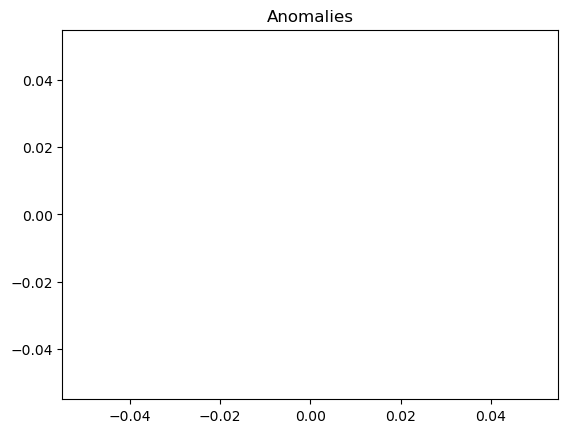

In [65]:
threshold_score=0.95
anomalous = np.where(maxes > threshold_score)
normal = np.where(maxes <= threshold_score)

plt.title("Anomalies")
plt.scatter(normal, seq_train[normal][:,-1], s=3)
#plt.scatter(anomalous, seq_train[anomalous][:,-1], s=5, c='r')
plt.show()

In [66]:
anomalous

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

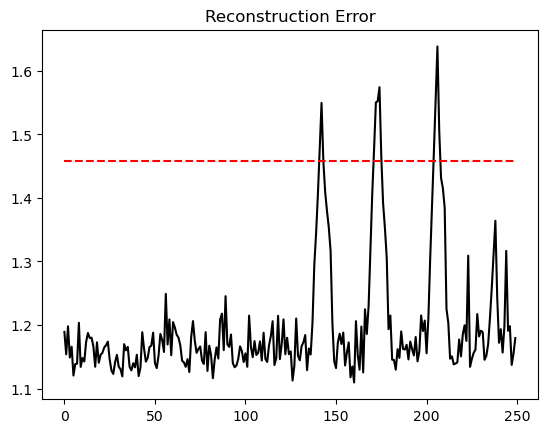

ValueError: x and y must be the same size

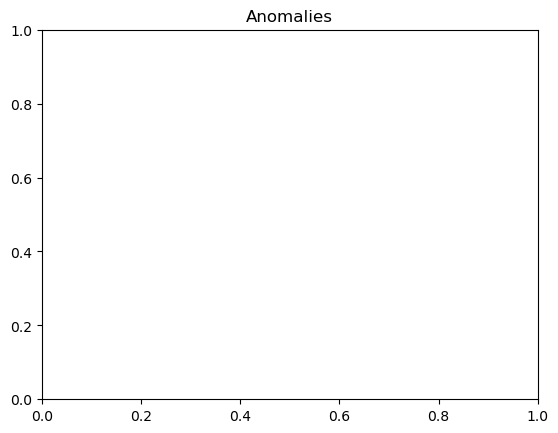

In [62]:
lstm_autoencoder2.plot(maxes, seq_train, threshold=0.95)

In [67]:
LoopFiles = 9
loops = int(len(BeforeTamping) / LoopFiles) 
if len(files)%LoopFiles != 0:
    loops += 1

st = ti()

Moves = []

for k in range(loops):
    if k == loops -1:
        tfiles = BeforeTamping[k*LoopFiles:]
    else:
        tfiles = BeforeTamping[k*LoopFiles:(k+1)*LoopFiles]
    #Results = Parallel(n_jobs=LoopFiles)(delayed(DeviationVelocity)(file) for file in tfiles)
    Results = Parallel(n_jobs=LoopFiles)(delayed(SmoothMoves)(file) for file in tfiles)
    #Results =[]
    #for file in tfiles:
    #    Results.append(DeviationVelocity(file))
    #    print(file, (ti()-st)/60.0)
    for result in Results:
        Moves.append(result)
    print(k, (ti()-st)/60.0)
        
Sequences = []
Outputs = []
for move in Moves:
    Seq, Out = split_sequences(move.T,TimeSteps,StepSize)
    Sequences.append(Seq)
    Outputs.append(Out)
print('Sequence Made ', (ti()-st)/60.0)
MoveSegments = []
for seq in Sequences:
    for mv in seq:
        MoveSegments.append(mv)
NextDataPoint = []
print('Moves Segmented ', (ti()-st)/60.0)
for out in Outputs:
    for pt in out:
        NextDataPoint.append(np.reshape(pt,(1,3)))
print('Done Prep ',(ti()-st)/60.0)

0 2.5975878477096557


In [74]:
Check1 = np.asarray(MoveSegments[:1000])

output_X = lstm_autoencoder2.model.predict(Check1)

32/32 [==============================] - 4s 111ms/step


In [ ]:
scores = np.linalg.norm(Check1 - output_X, axis=-1)

In [81]:
maxes = np.max(scores, axis = 1)

In [82]:
np.shape(maxes)


(1000,)

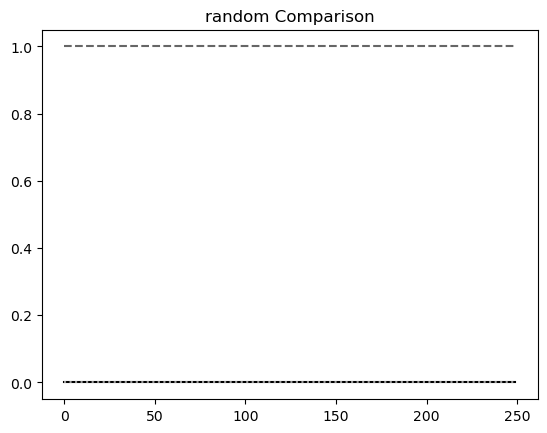

In [88]:
plt.title('random Comparison')
#plt.plot(MoveSegments[1][:,0])
plt.plot(output_X[99])
plt.show()

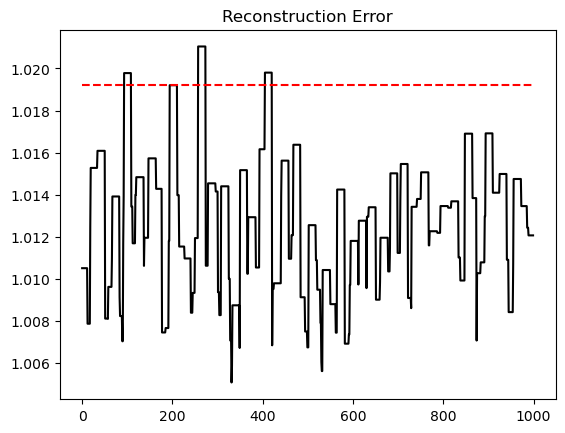

In [83]:
threshold = 0.95

sorted_scores = sorted(maxes)
threshold_score = sorted_scores[round(len(maxes) * threshold)]

plt.title("Reconstruction Error")
plt.plot(maxes)
plt.plot([threshold_score]*len(scores), c='r')
plt.show()
